# Featurization

This notebook is intended to featurize the data associated with CRISPRi activity scores to make it easier to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

###  _TODO: Create similar contribution graph_
### _TODO:  Z-standardize all numerical data__


__Bold == Featurized!__

Features available from data:
- Distance to TSS (primary and secondary, downstream and upstream)
- __sgRNA length__
- __(+) or (-) stranded sgRNA__
- __Longest consecutive run of each base__
- __Overall nucleotide composition (% of A, C, T, G, GC, CA, AG)__
- __Nucleotides at each position__
- __Nucleotides dimers at each position__

Features unavailable (stretch goal):
- DNAse-seq signal
- MNase-seq signal
- FAIRE-seq signal
- sgRNA overall folding free energy
- RNA pairing at each position





In [1]:
### IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
### READ DFs
activity_score_df = pd.read_csv('CRISPRi_Activity_Score_Data.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

In [4]:
### IMPORT CHECKs
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [5]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


In [6]:
activity_score_df['sgRNA sequence'] = activity_score_df['sgRNA sequence'].str.upper()

In [7]:
# Treat as categorical feature, there is a function for this ... 
activity_score_df['+ strand'] = 1*(activity_score_df['strand targeted'] == '+')
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",+ strand
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1


# Longest consecutive run of each base 

In [180]:
# `base` is the nucleotide: 'A', 'C', 'T', 'G'
# `seq` is the sequence string
def longest_consec(seq):
    max_count = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    count = 0
    current_base = None
    for char in seq:
        if char == current_base:
            count += 1
        else:
            if current_base != None and count > max_count[current_base]:
                max_count[current_base] = count
            current_base = char
            count = 1
    return [max_count['A'], max_count['C'], max_count['G'], max_count['T']]
    

In [181]:
# Longest consecutive run of each base
longest_cons = pd.DataFrame(activity_score_df['sgRNA sequence'].apply(longest_consec).tolist(),
                           columns = ['Longest A Run', 'Longest C Run', 
                                        'Longest G Run', 'Longest T Run'])
pd.concat([activity_score_df, longest_cons], axis=1, sort=False)

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",+ strand,Longest A Run,Longest C Run,Longest G Run,Longest T Run
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
18375,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1,2,1,3,2
18376,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1,3,1,1,2
18377,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0,1,1,4,1
18378,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0,2,2,2,1


(array([ 314., 1687., 5072.,    0., 9882.,  884.,    0.,  307.,  147.,
          87.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <a list of 10 Patch objects>)

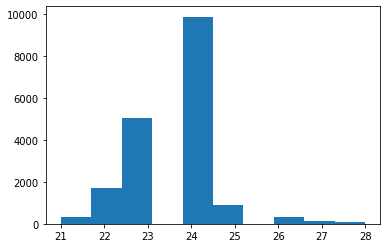

In [78]:
plt.hist(activity_score_df['sgRNA length (including PAM)'])

# Nucleotides at each position.
# Featurized as numbers

In [102]:
max_len = max(activity_score_df['sgRNA sequence'].str.len())
sgRNA_seq = activity_score_df['sgRNA sequence'].str.split('', expand=True)
sgRNA_seq['Length'] = activity_score_df['sgRNA sequence'].str.len()
# drop blank columns containing all empty strings
sgRNA_seq.drop(columns = [0, 26],  inplace=True)
# replace empty strings with 'None'
sgRNA_seq.replace(to_replace='', value=None, inplace=True)
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Length
0,G,C,G,C,T,C,T,G,A,T,...,G,A,G,C,G,,None,None,None,21
1,G,C,C,C,C,A,G,G,A,T,...,C,C,G,C,G,,None,None,None,21
2,G,G,C,C,G,C,C,C,T,C,...,C,T,C,T,G,,None,None,None,21
3,G,A,C,G,G,C,G,A,C,C,...,G,A,G,G,T,,None,None,None,21
4,G,G,T,G,C,A,G,C,G,G,...,G,G,C,G,G,,None,None,None,21


In [103]:
# Need numerical fetaures for ML. 
# Nucleotides at each position.
sgRNA_seq.replace(to_replace='A', value=0, inplace=True)
sgRNA_seq.replace(to_replace='C', value=1, inplace=True)
sgRNA_seq.replace(to_replace='G', value=2, inplace=True)
sgRNA_seq.replace(to_replace='T', value=3, inplace=True)
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Length
0,2,1,2,1,3,1,3,2,0,3,...,2,0,2,1,2,,None,None,None,21
1,2,1,1,1,1,0,2,2,0,3,...,1,1,2,1,2,,None,None,None,21
2,2,2,1,1,2,1,1,1,3,1,...,1,3,1,3,2,,None,None,None,21
3,2,0,1,2,2,1,2,0,1,1,...,2,0,2,2,3,,None,None,None,21
4,2,2,3,2,1,0,2,1,2,2,...,2,2,1,2,2,,None,None,None,21


# Overall nucleotide composition.

In [105]:
As = []
Cs = []
Gs = []
Ts = []
for index, row in sgRNA_seq.iterrows():
    As.append(sum(row == 0)/row['Length'])
    Cs.append(sum(row == 1)/row['Length'])
    Gs.append(sum(row == 2)/row['Length'])
    Ts.append(sum(row == 3)/row['Length'])
sgRNA_seq['As'] = As
sgRNA_seq['Cs'] = Cs
sgRNA_seq['Gs'] = Gs
sgRNA_seq['Ts'] = Ts
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,Length,As,Cs,Gs,Ts
0,2,1,2,1,3,1,3,2,0,3,...,2,,None,None,None,21,0.142857,0.238095,0.428571,0.238095
1,2,1,1,1,1,0,2,2,0,3,...,2,,None,None,None,21,0.142857,0.523810,0.333333,0.095238
2,2,2,1,1,2,1,1,1,3,1,...,2,,None,None,None,21,0.095238,0.380952,0.428571,0.190476
3,2,0,1,2,2,1,2,0,1,1,...,3,,None,None,None,21,0.238095,0.238095,0.476190,0.095238
4,2,2,3,2,1,0,2,1,2,2,...,2,,None,None,None,21,0.047619,0.333333,0.523810,0.190476


(array([2.516e+03, 3.359e+03, 5.327e+03, 4.537e+03, 1.651e+03, 7.380e+02,
        1.760e+02, 6.100e+01, 1.000e+01, 5.000e+00]),
 array([0.        , 0.07368421, 0.14736842, 0.22105263, 0.29473684,
        0.36842105, 0.44210526, 0.51578947, 0.58947368, 0.66315789,
        0.73684211]),
 <a list of 10 Patch objects>)

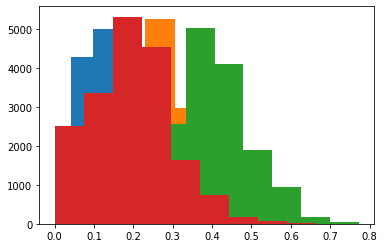

In [142]:
# Look at nucleotide distribution
plt.hist(sgRNA_seq['As'])
plt.hist(sgRNA_seq['Cs'])
plt.hist(sgRNA_seq['Gs'])
plt.hist(sgRNA_seq['Ts'])

# Nucleotide Dimers

In [115]:
def break_seq(seq):
    return [char for char in seq]

def break_seq_dimer(seq):
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [116]:
# pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq))
pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq).tolist())

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,G,C,G,C,T,C,T,G,A,T,...,G,G,A,G,C,G,None,None,None,None
1,G,C,C,C,C,A,G,G,A,T,...,C,C,C,G,C,G,None,None,None,None
2,G,G,C,C,G,C,C,C,T,C,...,G,C,T,C,T,G,None,None,None,None
3,G,A,C,G,G,C,G,A,C,C,...,A,G,A,G,G,T,None,None,None,None
4,G,G,T,G,C,A,G,C,G,G,...,T,G,G,C,G,G,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,G,T,A,A,T,C,T,T,A,G,...,G,T,G,G,G,A,None,None,None,None
18376,G,T,G,A,C,T,T,C,A,A,...,T,C,T,T,A,None,None,None,None,None
18377,G,T,G,G,A,T,G,T,G,G,...,G,G,C,G,A,A,None,None,None,None
18378,G,A,C,A,C,C,T,C,A,G,...,T,A,A,G,A,C,None,None,None,None


In [139]:
# Nucleotide dimers
encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7, 
             'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
sgRNA_dimers = pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq_dimer).tolist())

for dimer, repl in encodings.items():
    sgRNA_dimers.replace(dimer, repl, inplace = True)
    
sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,9,6,9,7,13,7,14,8,3,15,...,6,10,8,2,9,6,None,None,None,None
1,9,5,5,5,4,2,10,8,3,13,...,5,5,5,6,9,6,None,None,None,None
2,10,9,5,6,9,5,5,7,13,6,...,2,9,7,13,7,14,None,None,None,None
3,8,1,6,10,9,6,8,1,5,5,...,8,2,8,2,10,11,None,None,None,None
4,10,11,14,9,4,2,9,6,10,10,...,15,14,10,9,6,10,None,None,None,None


# Overall dimer composition.

In [141]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []
for index, row in sgRNA_seq.iterrows():
    GC.append(sum(row == encodings['GC']))
    CA.append(sum(row == encodings['CA']))
    AG.append(sum(row == encodings['AG']))

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers.head()             

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,GC,CA,AG
0,9,6,9,7,13,7,14,8,3,15,...,2,9,6,None,None,None,None,0,0,9
1,9,5,5,5,4,2,10,8,3,13,...,6,9,6,None,None,None,None,0,0,7
2,10,9,5,6,9,5,5,7,13,6,...,13,7,14,None,None,None,None,0,0,8
3,8,1,6,10,9,6,8,1,5,5,...,2,10,11,None,None,None,None,0,0,9
4,10,11,14,9,4,2,9,6,10,10,...,9,6,10,None,None,None,None,0,0,11


(array([ 715.,  615., 2982., 2560., 5830., 2419., 2607.,  441.,  199.,
          12.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

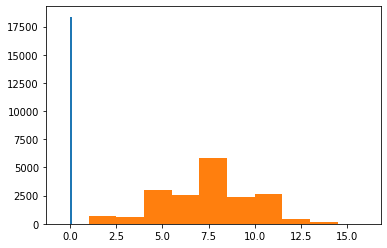

In [147]:
# See distribution
# plt.hist(sgRNA_dimers['GC'])
# plt.hist(sgRNA_dimers['CA'])
# plt.hist(sgRNA_dimers['AG'])

# TSS Annotations

In [11]:
genes = activity_score_df['gene symbol'].unique()
genes
len(genes)

1539

In [12]:
genes_tss = tss_annotation_df['gene'].tolist()

In [13]:
dup_genes_tss = tss_annotation_df['gene'][tss_annotation_df['gene'].duplicated()].unique()

In [14]:
sum(np.isin(genes, dup_genes_tss))

75

In [15]:
genes[np.isin(genes, dup_genes_tss)]

array(['ATP5A1', 'ATP5J2-PTCD1', 'BCL2L1', 'BOD1L1', 'C11orf45', 'CANX',
       'CBFA2T3', 'CCNK', 'CDK6', 'CENPA', 'CKAP5', 'COPS7B', 'COPZ1',
       'DDX46', 'DDX54', 'DHODH', 'DNASE1L1', 'DPH1', 'DYNLRB1', 'EEF2',
       'EIF4G2', 'ESF1', 'FBXO8', 'FDFT1', 'FIS1', 'FOLR3', 'GON4L',
       'HAUS7', 'HMG20B', 'IDH3A', 'IFT74', 'IK', 'IL11RA', 'KMT2B',
       'LDB1', 'LSM5', 'MAPKAP1', 'MRPL30', 'MTHFD2', 'NDUFC1', 'NDUFS5',
       'NDUFV1', 'OAZ3', 'PKM', 'PMPCB', 'PNISR', 'POLR1D', 'POLR2D',
       'PPP2R1A', 'PRMT5', 'PSMB6', 'PSPH', 'PTCD1', 'RAB5C', 'RBM4',
       'RPS29', 'RSL1D1', 'SEC61A1', 'SF3A1', 'SLC12A9', 'SLC1A5', 'SNW1',
       'ST3GAL2', 'STAG2', 'TACC3', 'TAL1', 'TKT', 'TUBB', 'UBA1',
       'USP39', 'WBP11', 'ZMAT2', 'ZMYM3', 'ZNF574', 'ZNF699'],
      dtype=object)

In [31]:
# Remove genes which are not in the TSS dataset.
activity_score_df = activity_score_df[np.isin(activity_score_df['gene symbol'].tolist(), genes_tss)]
print(sum(activity_score_df['gene symbol'] == 'NIFK'))
activity_score_df.head()

0


,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [37]:
# # Remove the genes which are represented by multiple transcripts in the TSS dataset.
# genes_tss = tss_annotation_df['gene'].unique()
# print(sum(np.logical_not(np.isin(genes, genes_tss))))
# print(np.isin(genes, genes_tss))
# # find index --> remove index 
dup_genes_tss = tss_annotation_df['gene'][tss_annotation_df['gene'].duplicated()].unique()
print(sum(np.isin(genes, dup_genes_tss)))
print(dup_genes_tss)

temp = activity_score_df[np.logical_not(np.isin(activity_score_df['gene symbol'].tolist(), dup_genes_tss))]
temp.info()


75
['A1BG' 'AARSD1' 'ABAT' ... 'LOC388813' 'LOC729574' 'PRAMEF22']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17250 entries, 0 to 18379
Data columns (total 7 columns):
gene symbol                                             17250 non-null object
chromosome                                              17250 non-null object
PAM genomic coordinate [hg19]                           17250 non-null int64
strand targeted                                         17250 non-null object
sgRNA length (including PAM)                            17250 non-null int64
sgRNA sequence                                          17250 non-null object
CRISPRi activity score [Horlbeck et al., eLife 2016]    17250 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ MB


In [203]:
genes[np.logical_not(np.isin(genes, genes_tss))]

array(['NIFK'], dtype=object)

In [40]:
tss_annotation_df.head(3)

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393


# Get distances to TSS start sites for each transcript

In [61]:
primary_five = []
primary_three = []
secondary_five = []
secondary_three = []
annot_genes = tss_annotation_df['gene']
for index, row in activity_score_df.iterrows():
    if index % 500 == 0:
        print(index)
    gene = row['gene symbol']
    PAM_coord = row['PAM genomic coordinate [hg19]']
    primary_five.append(PAM_coord - tss_annotation_df["Primary TSS, 5'"][annot_genes == gene].values[0])
    primary_three.append(PAM_coord - tss_annotation_df["Primary TSS, 3'"][annot_genes == gene].values[0])
    secondary_five.append(PAM_coord - tss_annotation_df["Secondary TSS, 5'"][annot_genes == gene].values[0])
    secondary_three.append(PAM_coord - tss_annotation_df["Secondary TSS, 3'"][annot_genes == gene].values[0])
    
activity_score_df['Dist to Primary TSS 5'] = primary_five
activity_score_df['Dist to Primary TSS 3'] = primary_three
activity_score_df['Dist to Secondary TSS 5'] = secondary_five
activity_score_df['Dist to Ssecondary TSS 5'] = secondary_three

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000


In [62]:
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",Dist to Primary TSS 5,Dist to Primary TSS 3,Dist to Secondary TSS 5,Dist to Ssecondary TSS 5
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,58,20,19,-22
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,-167,-205,-206,-247
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,-87,-125,-126,-167
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,-65,-103,-104,-145
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,-21,-59,-60,-101


Note: the NIFK gene is not in the TSS data. For now, we simply removed this gene from our analysis, but may explore this more later. 

We are also checking if any of the entires in the activity_df are of duplicated genes in the TSS annotation (in which case transcript is required to specify which one). For now, we also removed the 75 which were duplicated, and we hope to revisit this. 

RNA folding metric package: https://scicrunch.org/resolver/SCR_008550

Averaging the signal at each base of the target site including the PAM. Custom Python scripts with the module bxpython (v0.5.0, https://github.com/bxlab/bx-python)

# Relationship between CRISPRi activity and sgRNA position relative to the TSS as predicted by SVR.

In [95]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [97]:
model = svm.SVR().fit(X, y)
model.score(x_test, y_test)

-0.05343531362356391

In [101]:
# SVR trained on an 80% division of the CRISPRi activity score dataset
# using the position of the sgRNA relative to the upstream end of TSS for each gene.
train_size = int(0.8 * activity_score_df.shape[0])
X = np.array(activity_score_df['Dist to Primary TSS 3'][0:train_size]).reshape(-1, 1)
y = np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]'][0:train_size])

x_test = np.array(activity_score_df['Dist to Primary TSS 3'][train_size:]).reshape(-1, 1)
y_test = np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]'][train_size:])

print(X.shape)
print(y.shape)
print(X)
print(y)

(14690, 1)
(14690,)
[[  20]
 [-205]
 [-125]
 ...
 [ -22]
 [ -94]
 [-103]]
[ 0.01932036  0.34889211  0.91240883 ...  0.47415147 -0.04741211
  0.7370698 ]


In [99]:
regr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
fit = regr.fit(X, y) 

# y_pred = regr.predict(x_test)
fit.score(x_test, y_test)
             

# Hyperparameter values for SVR were selected automatically using cross-validation 
# within the training set. 



-0.05295051456507504

In [112]:
from sklearn.metrics import roc_auc_score

In [118]:
def regression_svm(
    x_train, y_train, x_test, y_test, logC, logGamma):
    '''
        Estimate a SVM regressor
    '''
    # create the regressor object
    sv = svm.SVR(kernel='rbf', 
        C=0.1 * logC, gamma=0.1 * logGamma)

    # estimate the model
    sv.fit(x_train,y_train)

    # decision function
    decision_values = sv.score(x_test, y_test)

    # return the object
    return decision_values

# find the optimal values of C and gamma 

In [125]:
scores = []

for C in range(1, 100):
    scores.append(regression_svm(X, y, x_test, y_test, C/100, C/100))

plt.scatter(scores)

KeyboardInterrupt: 

In [158]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVR()
clf = GridSearchCV(svr, param_grid)
model = clf.fit(X, y)
model.score(X)




ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [162]:
model.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': [{'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['rbf']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [ ]:
# To display the relationship between sgRNA position and CRISPRi activity fit by this model, 
# predicted scores were generated for each position within a 3 kb window around the TSS. 
# Graph produced --> lets make it too!!!

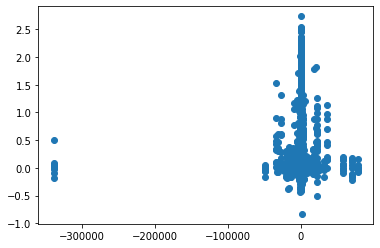

In [126]:
#x_pseudo = np.arange(-1500,1500)
#y_pred = regr.predict(x_pseudo.reshape(-1, 1))
#plt.scatter(x_pseudo, y_pred)
plt.scatter(X, y)

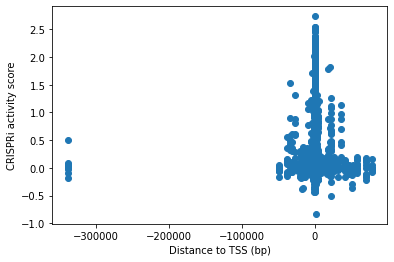

In [92]:
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('CRISPRi activity score')
plt.scatter(np.array(activity_score_df['Dist to Primary TSS 5']), np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]']))

In [128]:
len(activity_score_df[activity_score_df['Dist to Primary TSS 5'] < -100000])

8

In [141]:
tmp = activity_score_df[(activity_score_df['Dist to Primary TSS 5'] > -1500) & (activity_score_df['Dist to Primary TSS 5'] < 1500)]
tmp.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",Dist to Primary TSS 5,Dist to Primary TSS 3,Dist to Secondary TSS 5,Dist to Ssecondary TSS 5
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,58,20,19,-22
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,-167,-205,-206,-247
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,-87,-125,-126,-167
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,-65,-103,-104,-145
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,-21,-59,-60,-101


In [166]:
train_size = int(0.8 * tmp.shape[0])
X = np.array(tmp['Dist to Primary TSS 5'][0:train_size]).reshape(-1, 1)
y = np.array(tmp['CRISPRi activity score [Horlbeck et al., eLife 2016]'][0:train_size])

x_test = np.array(tmp['Dist to Primary TSS 5'][train_size:]).reshape(-1, 1)
y_test = np.array(tmp['CRISPRi activity score [Horlbeck et al., eLife 2016]'][train_size:])

regr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
fit = regr.fit(X, y) 

# y_pred = regr.predict(x_test)
fit.score(X, y)


0.015157855602923929

In [157]:
preds = fit.predict(X.reshape(-1, 1))
resid = sum((preds - y)**2)
ybar = np.mean(y)
tot = sum((y - ybar)**2)
1 - resid / tot

0.016309751550210527

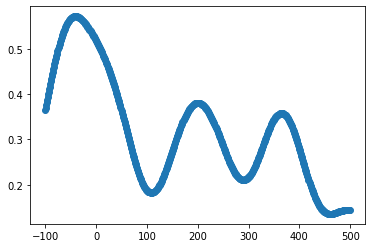

In [165]:
x_pseudo = np.arange(-100,500)
y_pred = model.predict(x_pseudo.reshape(-1, 1))
plt.scatter(x_pseudo, y_pred)

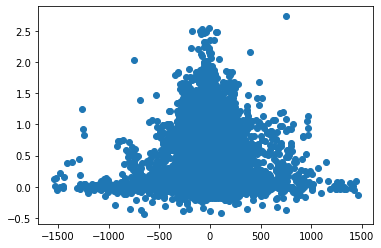

In [144]:
plt.scatter(X, y)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9fb70eb6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9fb70ebda0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9fb70eb550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9fb71174e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9fb7117860>],
 'means': []}

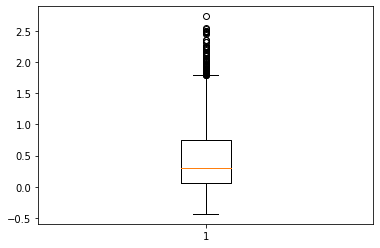

In [147]:
plt.boxplot(y)